# Ali Flu Project 10x - Blood Samples from P04, P05 and P11 (Year 1 and Year 2) without integration
* Hailong

In [1]:
## load libraries ####
rm(list=ls())
start_time <- Sys.time()
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("cowplot"))
suppressPackageStartupMessages(library("pheatmap"))
suppressPackageStartupMessages(library("RColorBrewer"))
suppressPackageStartupMessages(library("Matrix"))
suppressPackageStartupMessages(library("alakazam"))
suppressPackageStartupMessages(library("tidyr"))
suppressPackageStartupMessages(library("gridExtra"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("scales"))
sampleCat = "Blood"
path.work = file.path("D:","Storage","Ali","10x", "Year2", "GEX", sampleCat)
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
setwd(path.work)
feature.cols = c("lightgray", "blue")

# Load mappings
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
mappings = filter(mappings, (SampleType == "IgD-BCell" | SampleType == "PBMC" | SampleType == "PBMC-ASC"))
dim(mappings)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'cowplot' was built under R version 3.6.1"
Warning message:
"package 'alakazam' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"


[1] 38  8

In [2]:
# Read in immunestates file
immunostates_file <- file.path(path.data, "immunostates.txt")
immunostates <- read.table(immunostates_file,header = TRUE,sep="\t") %>%
    gather("KNOWN", "EXPR", -Gene) %>%
    rename(GENE = Gene) %>%
    mutate(EXPR = log(EXPR))

In [3]:
# load saved meta pulled from Ensembl 93 using biomaRt
load(file.path(path.data, "QC_features_meta.RData"))

# CellRanger will always return the same number of features in the GEX matrix 
# as long as the same 10x reference is used 
# In this case, for the reference I used, it's 33538 features
dim(features_meta)
#[1] 33538     5

# biotypes of features
# The IG_ and TR_ ones are the ones to exclude
table(features_meta[["gene_biotype"]])
 
# get a vector of IG and TR genes 
# do this by subsetting $gene_biotype (as opposed to basing off gene names)
biotypes_excl = unique(features_meta[["gene_biotype"]])[grepl(pattern="^IG_|^TR_", x=unique(features_meta[["gene_biotype"]]))]
remove.genes = features_meta[["external_gene_name"]][features_meta[["gene_biotype"]] %in% biotypes_excl]

[1] 33538     5


      antisense       IG_C_gene IG_C_pseudogene       IG_D_gene       IG_J_gene 
           5497              14               9              37              18 
IG_J_pseudogene       IG_V_gene IG_V_pseudogene         lincRNA  protein_coding 
              3             144             188            7484           19912 
      TR_C_gene       TR_D_gene       TR_J_gene TR_J_pseudogene       TR_V_gene 
              6               4              79               4             106 
TR_V_pseudogene 
             33 

## Read in data and apply filters¶

In [4]:
obj_list <- list()
gene_use=c()
for(samplePath in mappings$SamplePath){     
    sample = mappings$SampleName[which(mappings$SamplePath == samplePath)]
    sample2 = mappings$SampleName2[which(mappings$SamplePath == samplePath)]
    sampleType = mappings$SampleType[which(mappings$SamplePath == samplePath)]
    day = mappings$Day[which(mappings$SamplePath == samplePath)]
    subject = mappings$Subject[which(mappings$SamplePath == samplePath)]
    cat(sample, '\n')    
    dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
    cat(dir.name.full, '\n')
    data <- Read10X(data.dir = dir.name.full)
    obj <- CreateSeuratObject(counts = data, project = sample, min.cells = 5, min.features = 400)
    obj$sampleName <- sample
    obj$sampleName2 <- sample2
    obj$sampleType <- sampleType
    obj$day <- day
    obj$subject <- subject
    
    #colnames(data) <- sapply(colnames(data), function(x) paste(sample, x, sep = '_'))
    obj <- RenameCells(object = obj, add.cell.id = sample)
    obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    gene.cutoff.high=7000
    obj <- subset(x = obj, subset = nFeature_RNA > 400 & nFeature_RNA < gene.cutoff.high & percent.mt < 15)
  
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", scale.factor = 10000)
    obj_list[[sample]] <- obj
    
}


P04_IgD-BCell_d0_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d0_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d12_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d12_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d14_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s14_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d90_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s90_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d120_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d120_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_PBMC-ASC_d5_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d5_PBMC_ASC-lib1/outs/filtered_feature_bc_matrix 
P04_PBMC-AS

## Read in data and apply filters¶

In [5]:
samples = mappings$SampleName
samples.left = samples[-c(1,2)]
immune.combined <- merge(obj_list[[samples[1]]] , obj_list[[samples[2]]])
for(sample in samples.left){
    immune.combined <- merge(immune.combined ,  obj_list[[sample]])
}
# remove obj_list & obj & data to save space
rm(obj)
rm(data)
rm(obj_list)
gc()


used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells    2505170  133.8    4252540   227.2    4252540   227.2
Vcells 1160041288 8850.5 4290342739 32732.8 5360424980 40896.8

## Number of cells in each sample after filtering

In [6]:
cell.count = as.matrix(table(Idents(immune.combined)))
colnames(cell.count) = "Cell Count"
cell.count

Cell Count
P04_IgD-BCell_d0_1_Y1    9498     
P04_IgD-BCell_d0_1_Y2   10635     
P04_IgD-BCell_d12_1_Y1  10346     
P04_IgD-BCell_d120_1_Y1  9722     
P04_IgD-BCell_d14_1_Y2  10080     
P04_IgD-BCell_d90_1_Y2   8864     
P04_PBMC-ASC_d5_1_Y1    14742     
P04_PBMC-ASC_d7_1_Y2    16239     
P05_IgD-BCell_d0_1_Y1    3896     
P05_IgD-BCell_d0_1_Y2    6734     
P05_IgD-BCell_d12_1_Y1   6400     
P05_IgD-BCell_d120_1_Y1  3624     
P05_IgD-BCell_d13_1_Y2   4811     
P05_IgD-BCell_d180_1_Y1  6359     
P05_IgD-BCell_d180_2_Y1  5994     
P05_IgD-BCell_d28_1_Y1   7730     
P05_IgD-BCell_d28_1_Y2   3129     
P05_IgD-BCell_d5_1_Y1    3249     
P05_IgD-BCell_d6_1_Y2    4492     
P05_IgD-BCell_d60_1_Y1   3053     
P05_IgD-BCell_d60_1_Y2   5720     
P05_IgD-BCell_d90_1_Y1   2927     
P05_IgD-BCell_d90_1_Y2   7143     
P05_IgD-BCell_d90_2_Y1   2811     
P05_PBMC_d0_2_Y1         7662     
P05_PBMC_d12_2_Y1        6675     
P05_PBMC_d120_1_Y1       5764     
P05_PBMC_d28_2_Y1        6278     
P05_PBMC_d5_2_Y1         6968     
P05_PBMC_d60_1_Y1        7430     
P11_IgD-BCell_d0_1_Y1    7162     
P11_IgD-BCell_d0_1_Y2    6022     
P11_IgD-BCell_d120_1_Y1  7791     
P11_IgD-BCell_d35_1_Y1   7181     
P11_IgD-BCell_d35_1_Y2   6396     
P11_IgD-BCell_d90_1_Y2   6636     
P11_PBMC-ASC_d6_1_Y1     7564     
P11_PBMC-ASC_d6_1_Y2     6423

After remvoing IG/TR genes, total gene count is:  1696 


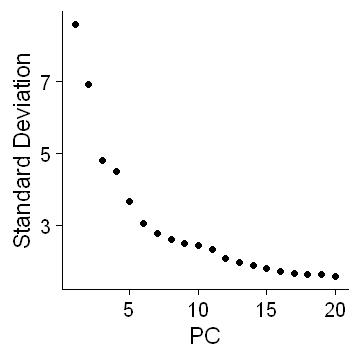

In [7]:
# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(object = immune.combined, verbose = FALSE)
immune.combined <- FindVariableFeatures(immune.combined, selection.method = "vst", nfeatures = 2000, do.plot = F)
bool.remove.genes <- immune.combined@assays$RNA@var.features %in% remove.genes
immune.combined@assays$RNA@var.features = immune.combined@assays$RNA@var.features[!bool.remove.genes]                     
cat('After remvoing IG/TR genes, total gene count is: ', length(immune.combined@assays$RNA@var.features), '\n')
immune.combined <- RunPCA(object = immune.combined, npcs = 30, verbose = FALSE)
options(repr.plot.width=3, repr.plot.height=3)
ElbowPlot(object = immune.combined)

In [8]:
# UMAP and Clustering
immune.combined <- RunUMAP(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 264150
Number of edges: 6843358

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9172
Number of communities: 26
Elapsed time: 176 seconds


In [8]:
if(0){immune.combined$sampleName = factor(immune.combined$sampleName, 
        levels = c('P04_IgD-BCell_0_Y1', 'P04_IgD-BCell_12_Y1', 'P04_IgD-BCell_120_Y1', 
                    'P04_PBMC-ASC_5_Y1',
                   
                    'P05_IgD-BCell_0_Y1','P05_IgD-BCell_5_Y1','P05_IgD-BCell_12_Y1','P05_IgD-BCell_28_Y1',
                    'P05_IgD-BCell_60_Y1','P05_IgD-BCell_90_Y1','P05_IgD-BCell_2_90_Y1','P05_IgD-BCell_120_Y1',
                    'P05_IgD-BCell_180_Y1','P05_IgD-BCell_2_180_Y1',
                    'P05_PBMC_2_0_Y1','P05_PBMC_2_5_Y1','P05_PBMC_2_12_Y1','P05_PBMC_2_28_Y1',
                    'P05_PBMC_60_Y1','P05_PBMC_120_Y1',
                  
                    'P11_IgD-BCell_0_Y1','P11_IgD-BCell_35_Y1','P11_IgD-BCell_120_Y1',
                    'P11_PBMC-ASC_6_Y1') )
immune.combined$sampleName2 = factor(immune.combined$sampleName2, 
        levels = c('P04_IgD-BCell_0_Y1', 'P04_IgD-BCell_12_Y1', 'P04_IgD-BCell_120_Y1', 
                    'P04_PBMC-ASC_5_Y1',
                  
                    'P05_IgD-BCell_0_Y1','P05_IgD-BCell_5_Y1','P05_IgD-BCell_12_Y1','P05_IgD-BCell_28_Y1',
                    'P05_IgD-BCell_60_Y1','P05_IgD-BCell_90_Y1','P05_IgD-BCell_120_Y1','P05_IgD-BCell_180_Y1',

                    'P05_PBMC_0_Y1','P05_PBMC_5_Y1','P05_PBMC_12_Y1',
                    'P05_PBMC_28_Y1', 'P05_PBMC_60_Y1','P05_PBMC_120_Y1',
                   
                    'P11_IgD-BCell_0_Y1','P11_IgD-BCell_35_Y1','P11_IgD-BCell_120_Y1',
                    'P11_PBMC-ASC_6_Y1'
                  ) )
     }

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 160826
Number of edges: 4395459

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9087
Number of communities: 24
Elapsed time: 89 seconds


2 singletons identified. 22 final clusters.


In [9]:
object.size(immune.combined)
#str(immune.combined)

30169924960 bytes

In [10]:
#options(repr.plot.width=6, repr.plot.height=3.5)
# visualize results of CCA plot CC1 versus CC2 and look at a violin plot
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleName")

In [11]:
#options(repr.plot.width=6, repr.plot.height=5)
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleType", split.by="sampleType")

In [9]:
options(repr.plot.width=8, repr.plot.height=7)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE)

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


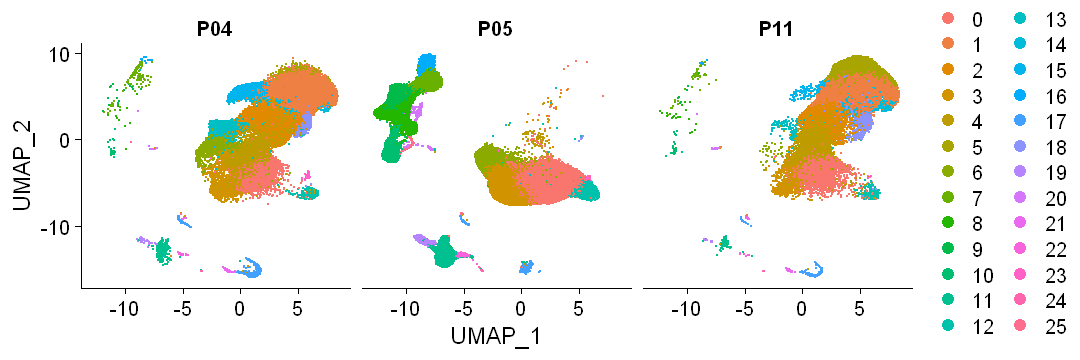

In [10]:
options(repr.plot.width=9, repr.plot.height=3)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject")

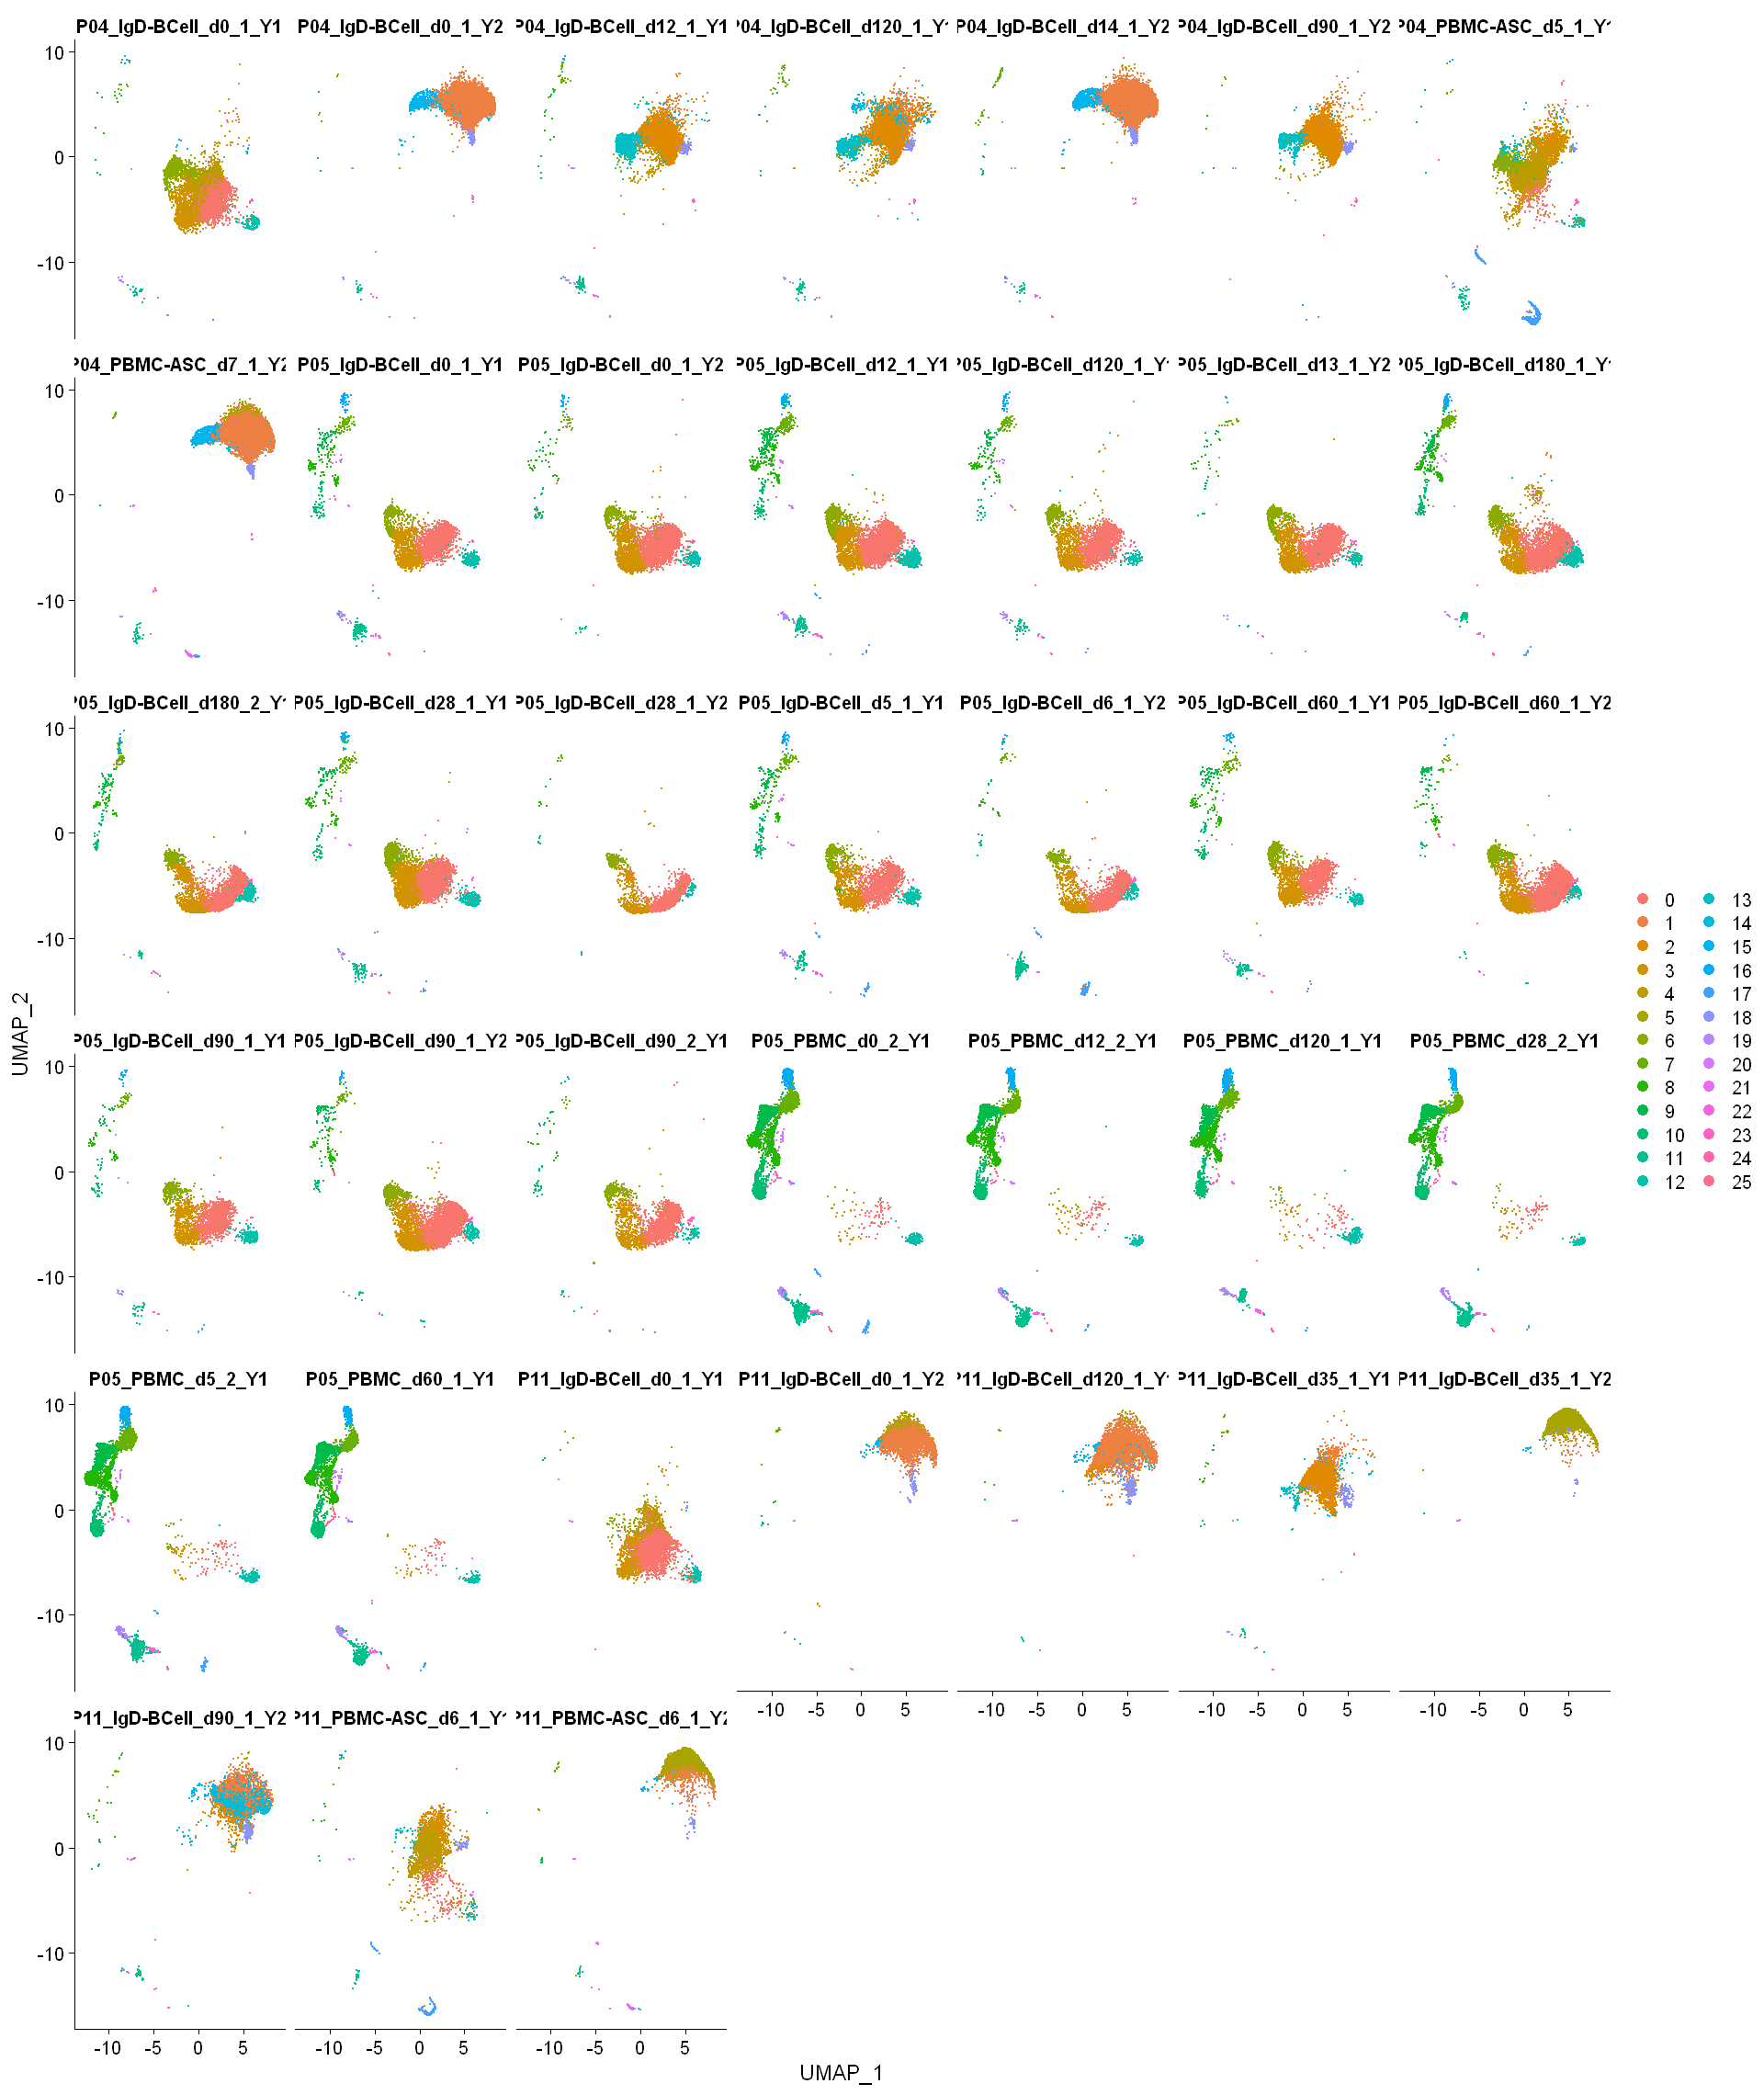

In [12]:
options(repr.plot.width=16, repr.plot.height=19)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName")

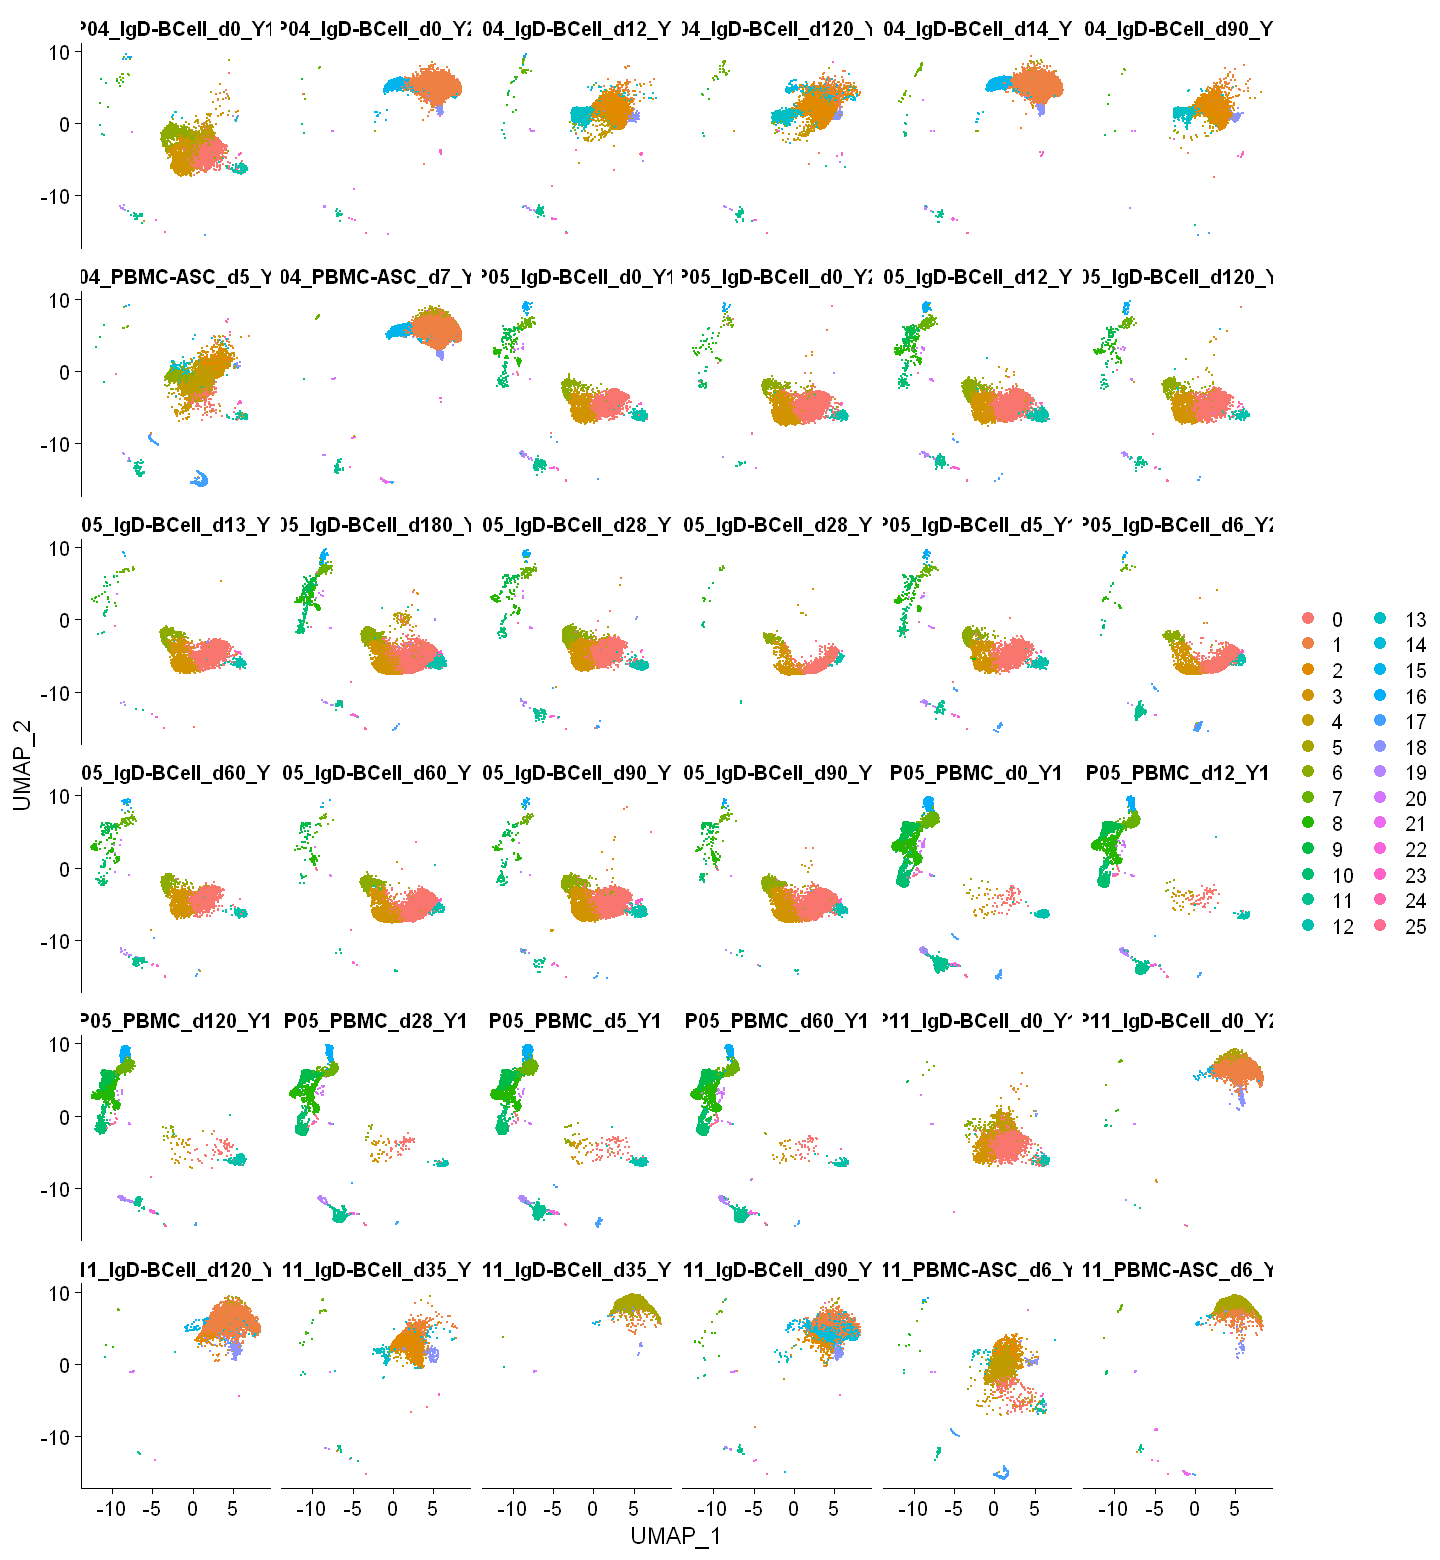

In [13]:
options(repr.plot.width=12, repr.plot.height=13)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName2")

## Check marker genes

In [14]:
B <- c("MS4A1", "IGKC","CD79A", "CD79B", "CD19")
RMB <- c("TNFRSF13B", "CD27", "CD24") #Resting Memory B
naive.B <- c("TCL1A", "IL4R",  "CCR7", "IGHM", "IGHD") #Naive B
plasma <- c("CD38", "CD27","FKBP11","TRIB1","SDC1","XBP1", "IRF4", "SEC11C", "JCHAIN", "PRDM1")
GC.B <- c("BCL6", "RGS13", "MEF2B", "STMN1", "ELL3", "SERPINA9")
ABC <- c("TBX21", "FCRL5", "ITGAX", "NKG7", "ZEB2", "CR2")# the lack of CR2 for activated B cells (ABCs);
T <- c("CD3D", "CD3E","CD4", "IL7R", "CD8A")
NK <- c("GZMB", "GNLY", "NKG7", "NCAM1")
CD14.Monocyte <-c("CD14","LYZ")
DC <- c("FCER1A", "CST3")
platlet <- "PPBP"
dividing  <- c("MKI67", "CDK1") # Dividing cells 
  
all.markers = unique(c(B, RMB, naive.B, plasma, GC.B, ABC, T, NK, CD14.Monocyte, DC, platlet, dividing))
            

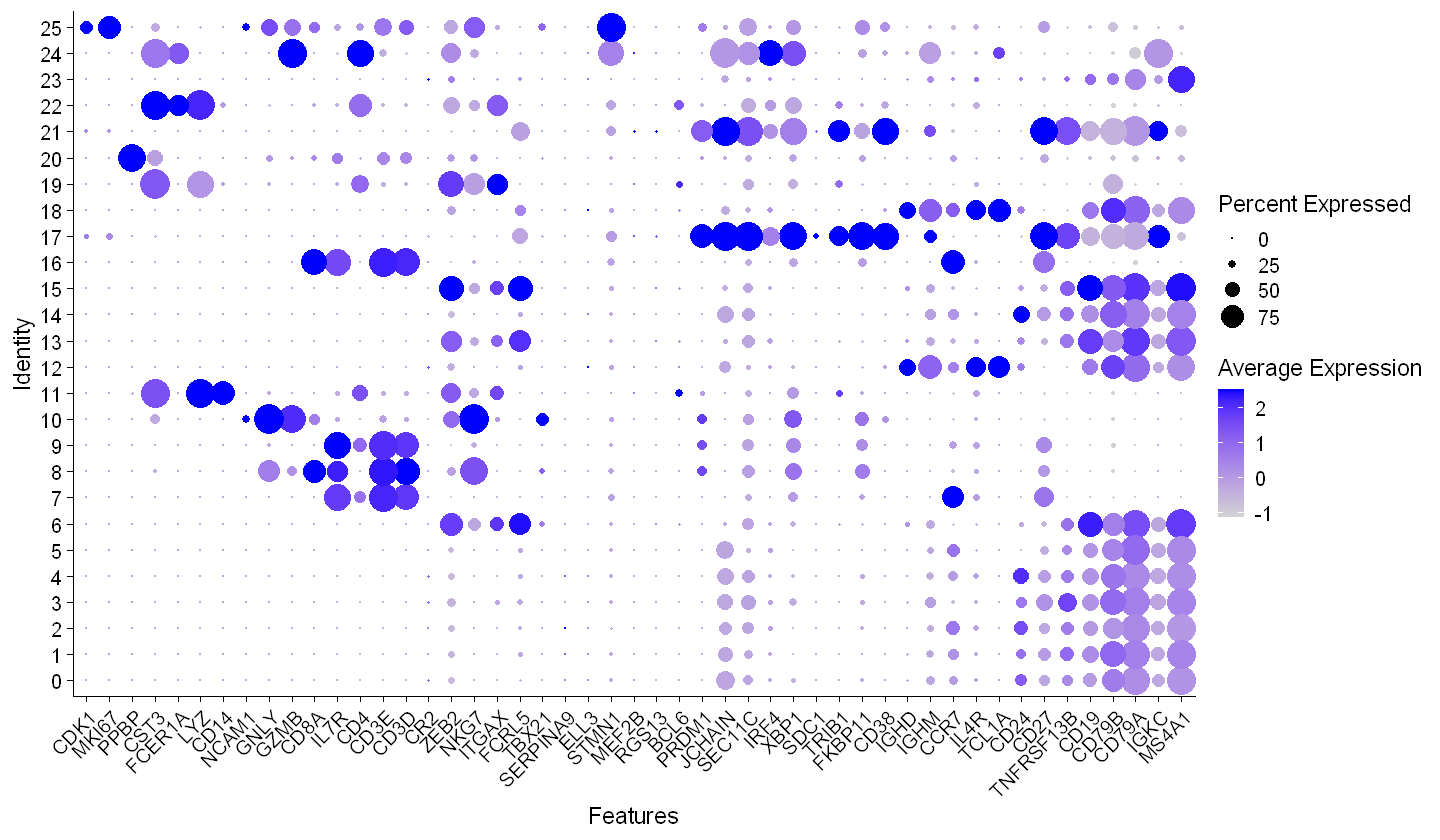

In [15]:
options(repr.plot.width=12, repr.plot.height=7)
DotPlot(immune.combined, assay = "RNA", features =  unique(all.markers), dot.scale = 8) + RotatedAxis()

### B cell markers

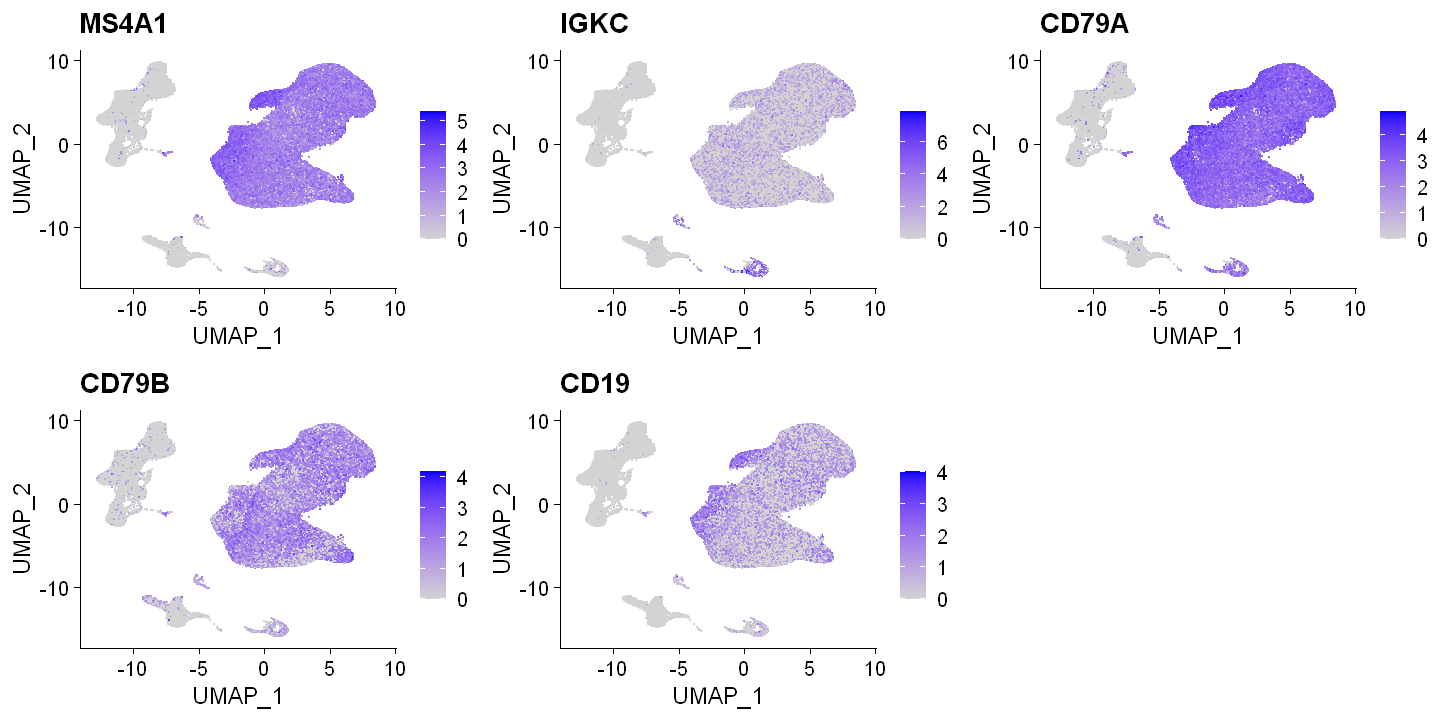

In [16]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Plasma markers

In [17]:
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(object = immune.combined, features = plasma, ncol =3,cols = feature.cols, min.cutoff = 0)

### Resting Memory B cells

In [18]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = RMB, ncol =3,cols = feature.cols, min.cutoff = 0)

### Naive B cells

In [19]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = naive.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Germinal Center B cells

In [20]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = GC.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Activated B cells

In [21]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = ABC, ncol =3,cols = feature.cols, min.cutoff = 0)

### T cell markers

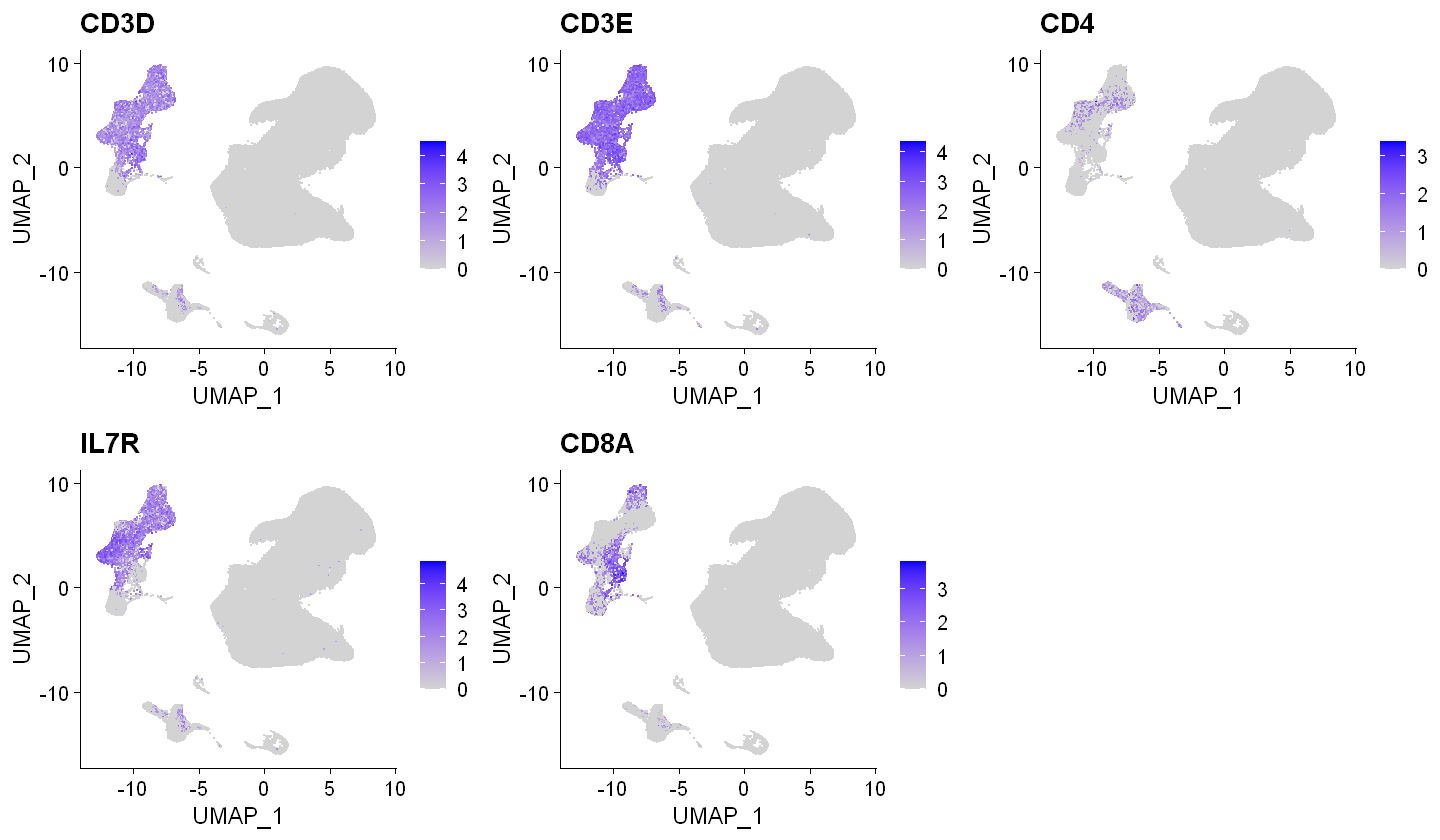

In [22]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = T, ncol =3,cols = feature.cols, min.cutoff = 0)

### NK cell markers

In [23]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = NK, ncol =3,cols = feature.cols, min.cutoff = 0)

### DC cell markers

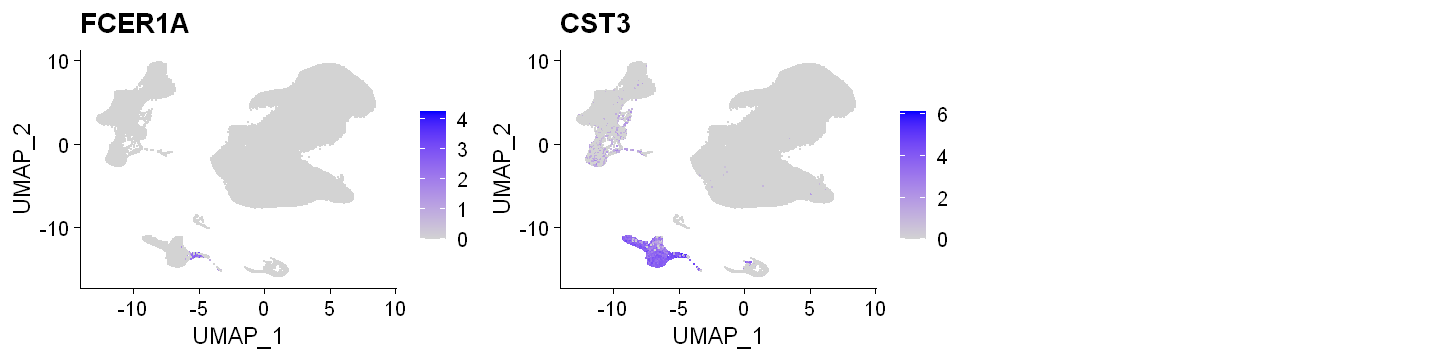

In [24]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = DC, ncol =3,cols = feature.cols, min.cutoff = 0)

### CD14 Monocyte

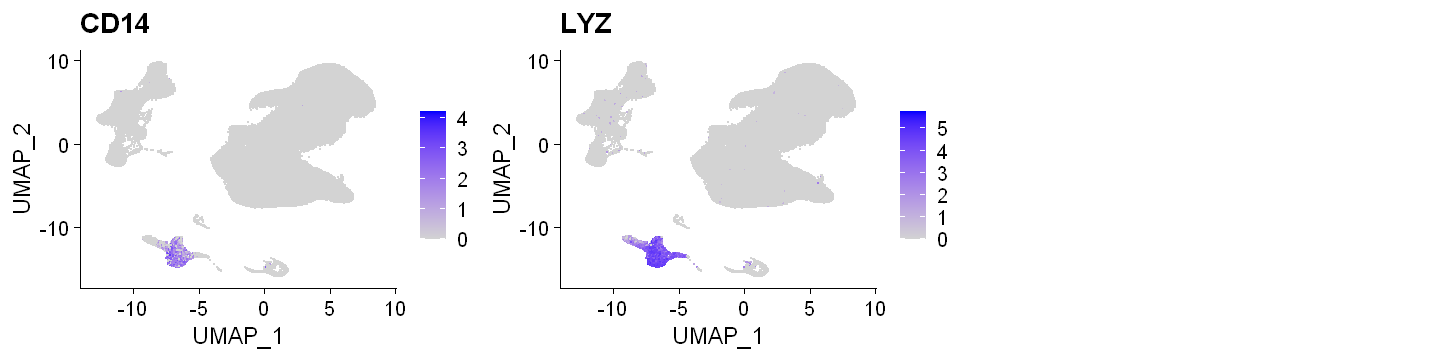

In [25]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = CD14.Monocyte, ncol =3,cols = feature.cols, min.cutoff = 0)

### Platlet

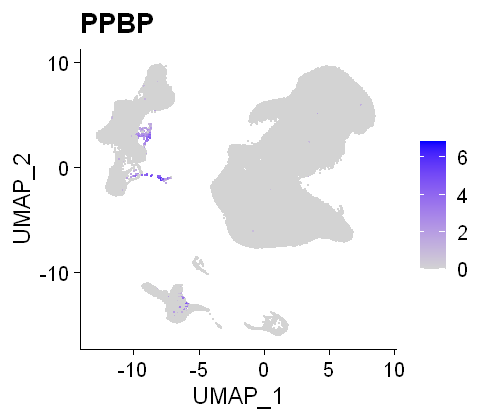

In [26]:
options(repr.plot.width=4, repr.plot.height=3.5)
FeaturePlot(object = immune.combined, features = platlet, cols = feature.cols, min.cutoff = 0)
 

### Dividing cells

In [27]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = dividing, ncol =3,cols = feature.cols, min.cutoff = 0)

# Cell type assignment by Immunostates

In [28]:
identities <- unique(Idents(immune.combined))
assignment_list <- list()
for(identity in identities){
    # mean expression of each gene in each cluster
    identity_cells <- data.frame(IDENTITY = Idents(immune.combined)) %>% 
        tibble::rownames_to_column("CELL") %>%
        filter(IDENTITY == identity) %>% select(CELL) %>% unlist()
    identity_obj <- subset(immune.combined, cells = identity_cells)
    #identity_mean_df <- data.frame(GetAssayData(object = identity_obj, slot = 'scale.data')) %>%
    #identity_mean_df <- data.frame(log(identity_obj@assays$RNA@counts+1) ) %>%
    identity_mean_df <- data.frame(identity_obj@assays$RNA@data) %>% # this data slot has normalized data
        tibble::rownames_to_column("GENE") %>%
        gather("CELL", "EXPR", -GENE) %>% 
        group_by(GENE) %>%
        summarize(EXPR_CLUSTER = mean(EXPR))
    
    # correlations of immunostate vectors with mean gene expression
    assignment_list[[identity]] <- immunostates %>%
        left_join(identity_mean_df, by="GENE") %>%
        drop_na(EXPR_CLUSTER) %>%
        filter(EXPR_CLUSTER != 0) %>%
        group_by(KNOWN) %>%
        summarize(COR = cor(EXPR,EXPR_CLUSTER))
}

ERROR: Error: Internal error in `dict_hash_with()`: Dictionary is full.


In [ ]:
assignment_df <- bind_rows(assignment_list, .id = "IDENTITY") %>% 
    group_by(IDENTITY) %>% 
    filter(COR == max(COR)) %>%
    arrange(as.numeric(IDENTITY))

assignment_df

In [45]:
# save for future use
path.work = file.path("D:","Storage","Ali","10x", "Year2", "GEX", sampleCat)
saveRDS(immune.combined, file.path(path.work, "Blood.GEX.Y1Y2.rds"))
#immune.combined <- readRDS("Blood.GEX.rds")

In [30]:
path.data = file.path("D:","Storage","Ali","10x","Year2","mergeBCR_Y1Y2","data")
BCR.Y1Y2.P04 = read.table(paste0(path.data, "/P04_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)
BCR.Y1Y2.P05 = read.table(paste0(path.data, "/P05_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)

BCR.Y1Y2.P04 = BCR.Y1Y2.P04 %>% 
        dplyr::filter((SAMPLETYPE == "IgD-BCell" | SAMPLETYPE == "PBMC" | SAMPLETYPE == "PBMC-ASC")  
                      & DATATYPE == "singleCell") 
BCR.Y1Y2.P05 = BCR.Y1Y2.P05 %>% 
        dplyr::filter((SAMPLETYPE == "IgD-BCell" | SAMPLETYPE == "PBMC" | SAMPLETYPE == "PBMC-ASC") 
                      & DATATYPE == "singleCell")
BCR.Y1Y2 = rbind(BCR.Y1Y2.P04, BCR.Y1Y2.P05)

In [43]:
BCR.Y1Y2$CELL = as.character(BCR.Y1Y2$CELL)
BCR.Y1Y2 = BCR.Y1Y2 %>% rowwise() %>%
            mutate(BARCODE = paste(SAMPLE, strsplit(CELL, split = "-")[[1]][1], sep = "_"))

b_cell.BM <- unique((BCR.Y1Y2 %>%
            filter(BARCODE %in% Cells(immune.combined)))$BARCODE)

length(b_cell.BM)
 

[1] 120251

In [44]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(object = immune.combined, reduction = "umap", cells.highlight = b_cell.BM, label = TRUE, 
        pt.size = 0.5,label.size=6, cols=feature.cols) + NoLegend()

In [46]:
immune.combined.B <- subset(immune.combined, 
                        idents = c('0','1','2','3','4','5','6','12','13','14','15','17','18','21','23'))
DimPlot(object = immune.combined.B, reduction = "umap", label = TRUE)

In [ ]:
saveRDS(immune.combined.B, file.path(path.work, "Blood.GEX.pre_B.Y1Y2.rds"))

In [10]:
anno.matrix = rbind(c("0", "TCL1A, IL4R, CCR7", "Naive B"),
                    c("1", "TCL1A, IL4R, CCR7", "Naive B"),
                    c("2", "TCL1A, IL4R, CCR7", "Naive B"),
                    c("3", "FCRL5, ITGAX,ZEB2", "ABC"),
                    c("4", "TNFRSF13B, CD27, CD24", "Memory B"),
                    c("5", "CD3E, CD4", "CD4 T"),
                    c("6", "CD3E, CD4", "CD4 T"),
                    c("7", "TNFRSF13B, CD27, CD24", "Memory B"),
                    c("8", "GZMB, GNLY, NKG7", "NK"),
                    c("9", "TCL1A, IL4R, CCR7", "Naive B"),
                    c("10", "CD14,CD16, LYZ", "DC/Monocyte"),
                    c("11", "CD3E, CD8A", "CD8 T"),
                    c("12", "CD3E, CD8A", "CD8 T"),
                    c("13", "CD3E, CD8A", "CD8 T"),
                    c("14", "CD38, CD27,FKBP11", "PB"),
                    c("15", "CD14,CD16, LYZ", "DC/Monocyte"),
                    c("16", "PPBP", "Platlet"),
                    c("17", "CD14,CD16, LYZ", "DC/Monocyte"),
                    c("18", "CD38, CD27,FKBP11", "PB"),
                    c("19", "CD14,CD16, LYZ", "DC/Monocyte"),
                    c("20", "TNFRSF13B, CD27, CD24", "Memory B"),
                    c("21", "CD3E, CD8A", "CD8 T")
                    )
colnames(anno.matrix) = c("Cluster ID", "Markers", "Cell Type")
anno.matrix

Cluster ID Markers               Cell Type  
 [1,] 0          TCL1A, IL4R, CCR7     Naive B    
 [2,] 1          TCL1A, IL4R, CCR7     Naive B    
 [3,] 2          TCL1A, IL4R, CCR7     Naive B    
 [4,] 3          FCRL5, ITGAX,ZEB2     ABC        
 [5,] 4          TNFRSF13B, CD27, CD24 Memory B   
 [6,] 5          CD3E, CD4             CD4 T      
 [7,] 6          CD3E, CD4             CD4 T      
 [8,] 7          TNFRSF13B, CD27, CD24 Memory B   
 [9,] 8          GZMB, GNLY, NKG7      NK         
[10,] 9          TCL1A, IL4R, CCR7     Naive B    
[11,] 10         CD14,CD16, LYZ        DC/Monocyte
[12,] 11         CD3E, CD8A            CD8 T      
[13,] 12         CD3E, CD8A            CD8 T      
[14,] 13         CD3E, CD8A            CD8 T      
[15,] 14         CD38, CD27,FKBP11     PB         
[16,] 15         CD14,CD16, LYZ        DC/Monocyte
[17,] 16         PPBP                  Platlet    
[18,] 17         CD14,CD16, LYZ        DC/Monocyte
[19,] 18         CD38, CD27,FKBP11     PB         
[20,] 19         CD14,CD16, LYZ        DC/Monocyte
[21,] 20         TNFRSF13B, CD27, CD24 Memory B   
[22,] 21         CD3E, CD8A            CD8 T

In [11]:
 levels(x = immune.combined)

[1] "0"  "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "21"
[16] "3"  "4"  "5"  "6"  "7"  "8"  "9"

In [12]:
# somehow the ident sorted in the order of 0,1,10,11,...,19,2,20,21,22,3,4,5,6,7,8,9 ,so need to change new.cluster.ids order to
new.cluster.ids <- c("Naive B", "Naive B","DC/Monocyte","CD8 T", "CD8 T", "CD8 T", "PB", "DC/Monocyte", "Platlet",
                    "DC/Monocyte", "PB", "DC/Monocyte","Naive B","Memory B","CD8 T","ABC", "Memory B", "CD4 T",
                     "CD4 T", "Memory B", "NK", "Naive B"
                     )
names(x = new.cluster.ids) <- levels(x = immune.combined)

[1] 22

In [15]:
immune.combined <- RenameIdents(object = immune.combined, new.cluster.ids)

In [16]:
options(repr.plot.width=5, repr.plot.height=4)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE, pt.size = 0.8,label.size=3) + NoLegend()

In [17]:
# save for future use
saveRDS(immune.combined, file.path(path.work, paste0(sampleCat,".GEX.rds")))

In [18]:
length(immune.combined@active.ident)
table(Idents(immune.combined))
table(immune.combined$sampleType)
prop.table(table(Idents(immune.combined),immune.combined$sampleType))
#prop.table(table(Idents(immune.combined)))

[1] 160826


    Naive B DC/Monocyte       CD8 T          PB     Platlet    Memory B 
      89458        7218       13325        2324         435       15769 
        ABC       CD4 T          NK 
       9858       16587        5852 


IgD-BCell      PBMC  PBMC-ASC 
    97743     40777     22306 

             
                 IgD-BCell         PBMC     PBMC-ASC
  Naive B     0.4324300797 0.0106326092 0.1131782175
  DC/Monocyte 0.0072749431 0.0371706067 0.0004352530
  CD8 T       0.0083382040 0.0744220462 0.0000932685
  PB          0.0004414709 0.0008953776 0.0131135513
  Platlet     0.0006590974 0.0020270354 0.0000186537
  Memory B    0.0940333031 0.0015233855 0.0024933779
  ABC         0.0517515825 0.0002735876 0.0092708890
  CD4 T       0.0096315272 0.0934301668 0.0000746148
  NK          0.0031960006 0.0331724970 0.0000186537